In [1]:
from Problem1.p1 import main as p1main

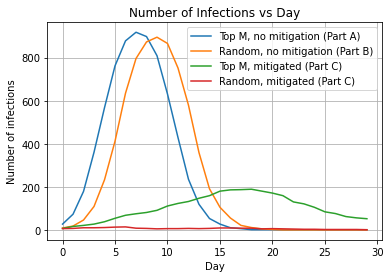

In [3]:
p1main()

We can see that having essential persons being targeted provides a similar curve shape to the non-mitigated experiments, but some form of isolation severely dampens the peak of the spread. Additionaly the virus spreads more slowly due to fewer people developing immunity, meaning that at a given timestep there are more people in the susceptible population. Having the patient 0's be random, leaves an almost flat curve. Though, we can understand that individuals most likely to contract the virus as a patient 0, would not be the ones with few connections. 

# Problem 2

In [23]:
import networkx as nx
import numpy as np
assigned_network = 'U546'

In [24]:
def build_network(network_fp, label_fp, *attribute_fps):
    global assigned_network      # Use global parameter 

    G = nx.DiGraph()
    with open(network_fp, 'r') as f:
        edges = []
        for l in f:
            g, src, dest = tuple(l.split())
            g, src, dest = g.strip(), src.strip(), dest.strip()
            # Assigned network
            if g != assigned_network:
                continue
            edges.append((src, dest))
        G.add_edges_from(edges)

    with open(label_fp, 'r') as f:
        labels = {}
        for l in f:
            src, dest, label = tuple(l.split())
            src, dest, label = src.strip(), dest.strip(), label.strip()
            if G.has_edge(src, dest):
                labels[(src, dest)] = label

        nx.set_edge_attributes(G, labels, 'label')

    for att_fp in attribute_fps:
        attrs = {}

        with open(att_fp, 'r') as f:
            attr_name = att_fp[att_fp.rfind('/')+1:-4]
            node = f.readline().strip()
            while node:
                num_attrs = int(f.readline())
                if node not in attrs.keys():
                    attrs[node] = {}

                for i in range(num_attrs):
                    attr = f.readline().strip()
                    attrs[node][f'{attr_name}_{i}'] = attr

                node = f.readline().strip()

        nx.set_node_attributes(G, attrs)

    return G         

In [25]:
network = './Problem2/EgoNetUIUC-LinkedinCrawl-Network_20150101/network.txt'
label = './Problem2/EgoNetUIUC-LinkedinCrawl-Network_20150101/label.txt'
college = './Problem2/EgoNetUIUC-LinkedinCrawl-Profile0101/college.txt'
employer = './Problem2/EgoNetUIUC-LinkedinCrawl-Profile0101/employer.txt'
location = './Problem2/EgoNetUIUC-LinkedinCrawl-Profile0101/location.txt'

G = build_network(network, label, college, employer, location)

In [26]:
nx.write_gexf(G, './Problem2/ego_net.gexf')

In [92]:
# Create circles 1-8
circles = [set() for i in range(8)]
# Iterate through edge types and append nodes to a python set
with open('./Problem2/EgoNetUIUC-LinkedinCrawl-Network_20150101/label.txt', 'r') as f:
    for l in f:
        src, dest, label = tuple(l.split())


        if src not in G.nodes:
            #print(f'{src} not in nodes')
            continue
        if not dest in G.neighbors(src):
            continue

        cid = int(label[-1])-1 # Circle id
        circles[cid].update({src, dest})



In [93]:
# Finally just create nx subgraphs with the sets as nodes
circle_feats = []
sgs = []
for i, c in enumerate(circles):
    sg = G.subgraph(c)
    sgs.append(sg)
    feats = {'college':{}, 'employer':{}, 'location':{}}
    scores = [-1, -1, -1]

    for feat in feats.keys():
        total = 0
        for n in sg.nodes:
            for f in sg.nodes[n]:
                if f.startswith(feat):
                    # Calculate empirical counts
                    val =sg.nodes[n][f]
                    if val not in feats[feat].keys():
                        feats[feat][val] = 1
                    else:
                        feats[feat][val] = feats[feat][val] + 1
                    total += 1

        for k, v in feats[feat].items():
            feats[feat][k] = v / total # Normalize empirical probabilities

    
    circle_feats.append(feats)

    # nx.write_gexf(sg, f'./Problem2/truth_circles/circle_{i+1}.gexf') # For visualization purposes

In [94]:
for circle in circle_feats:
    for feat in circle.keys():
        entropy = 0
        for k, v in circle[feat].items():
            entropy -= v * np.log(v)
        circle[feat] = entropy

In [101]:
for i, circle in enumerate(circle_feats):
    print(f'CIRCLE {i+1}')
    print('-'*75)
    if len(sgs[i].nodes) > 0:
        clustering = nx.average_clustering(sgs[i])
        college = circle['college']
        location = circle['location']
        employer = circle['employer']

    else:
        clustering = '*'
        college = '*'
        employer = '*'
        location = '*'
    
    print('Clustering Coeff:', clustering)
    print('Homo College:', college)
    print('Homo Employer:', employer)
    print('Homo Location:', location)

CIRCLE 1
---------------------------------------------------------------------------
Clustering Coeff: 0.0
Homo College: 0.6931471805599453
Homo Employer: 1.3862943611198906
Homo Location: 0.6931471805599453
CIRCLE 2
---------------------------------------------------------------------------
Clustering Coeff: 0.0
Homo College: 0.6931471805599453
Homo Employer: 2.0794415416798357
Homo Location: 0.6931471805599453
CIRCLE 3
---------------------------------------------------------------------------
Clustering Coeff: 0.14377289377289376
Homo College: 0.6931471805599453
Homo Employer: 2.7849920002108464
Homo Location: 1.90853528164356
CIRCLE 4
---------------------------------------------------------------------------
Clustering Coeff: 0.0
Homo College: 0.6931471805599453
Homo Employer: 2.1972245773362196
Homo Location: 0.9502705392332347
CIRCLE 5
---------------------------------------------------------------------------
Clustering Coeff: *
Homo College: *
Homo Employer: *
Homo Location: *

## For the entire ego net:

Average Degree: 2.406  
Average Clustering Coefficient: 0.237  
Average Path length: 1.9618055555555556  
Number of Communities: 3  

2.3:

a. How homogeneous are communities in your ego-network? Do they tend to share similar characteristics? 
Do similar people belong to the same communities? 

Community 8 specifically has a very high clustering coefficient since there is a lot of interconnectivity.
Communities 7, 5, 2, and 1 all do not exist in any meaningful capacity.
Community 3 shows lower entropy (and therefore more similar characteristics) than community 8 despite its much lower clustering coefficient.
There is no distinct relationship between clustering coefficient and entropy of features, therefore I cannot conclude that these communities are homogenous.

b. How  interconnected  is  your  LinkedIn  ego-network?  Is  there  a  high  degree  of  overlap  between 
communities in your ego-network?

There is a lot of overlap between circles 6 and 8 as nearly all of circle 8 is also in circle 5. However, beyond that pair, there is little to no overlap between communities, and the little overlap that does exist is typically only the root node of the ego network.

In [103]:
import itertools

In [120]:
[(i, j, len(circles[i].intersection(circles[j]))) for i, j in itertools.combinations(np.arange(8), 2)]

[(0, 1, 0),
 (0, 2, 0),
 (0, 3, 0),
 (0, 4, 0),
 (0, 5, 1),
 (0, 6, 0),
 (0, 7, 1),
 (1, 2, 2),
 (1, 3, 0),
 (1, 4, 0),
 (1, 5, 0),
 (1, 6, 0),
 (1, 7, 0),
 (2, 3, 1),
 (2, 4, 0),
 (2, 5, 1),
 (2, 6, 0),
 (2, 7, 1),
 (3, 4, 0),
 (3, 5, 1),
 (3, 6, 0),
 (3, 7, 1),
 (4, 5, 0),
 (4, 6, 0),
 (4, 7, 0),
 (5, 6, 0),
 (5, 7, 8),
 (6, 7, 0)]

In [122]:
len(circles[5]), len(circles[7])

(26, 10)